# <span style="color:black; font-weight:bold;">Label Transfer and Cross platform generalization</span>

+ <span style="color:black; font-weight:bold;">Creator</span>: Bingjie Dai (17516970902@163.com)
+  <span style="color:black; font-weight:bold;">Date of Creation</span>: 10.14.2025
+ <span style="color:black; font-weight:bold;">Date of Last Modification</span>: 10.14.2025
+ <span style="color:black; font-weight:bold;">Download</span>: Pre-training data and Trained SpaLP model used in the tutorial are available at [Pre-training.h5ad](https://drive.google.com/open?id=1V_BwW-bKaHw1ogECOiwXmZEop6TRV9h5&usp=drive_fs) , [Trained SpaLP model](https://drive.google.com/open?id=1DIXy_qsLbVvDkD4thTe3039GKnbPqyco&usp=drive_fs)
+ <span style="color:black; font-weight:bold;">Download</span>: New data are available at [MERFISH_animal2.h5ad](https://drive.google.com/open?id=1xTO8Wgs1_6eNeXeQF_3TMgUghrASvdS1&usp=drive_fs) and [Stereo-seq:C03937C4.adjusted.h5ad](https://drive.google.com/open?id=1nBGpBO6FnlhCiFxuYAm4SCCxV8MDWYt6&usp=drive_fs)
Stereo-seq data is from [STOmics](https://www.stomics.tech/col1357)
+ <span style="color:black; font-weight:bold;">In this tutorial we show how to use a SpaLP pre-trained model to perform label transfer on a new data set</span>

In [1]:
from SpaLP.utils import prepare_inputs, set_seed,create_new_color_dict,Graph,transfer_labels_by_cosine
from SpaLP.RandLA import SpatialAutoencoder
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
set_seed(7)

## <span style="color:black; font-weight:bold;">Loading a new MERFISH Mouse Brain data</span>

In [4]:
adata=sc.read_h5ad('/home/dbj/SpaLA/Batch/MERFISH/MERFISH_animal2.h5ad')
adata.var_names=adata.var['gene_name']
adata.obs['slice']=adata.obs['brain_section_label']
adata.obsm['spatial']=adata.obsm['X_spatial_coords']
adata=adata[adata.obs['slice']=='C57BL6J-2.041']
adata.raw=adata

## <span style="color:black; font-weight:bold;">Loading Pre-training data</span>

In [5]:
Pre_train_data=sc.read_h5ad('/home/dbj/SpaLP/generalization/Pre-training.h5ad')

## <span style="color:black; font-weight:bold;">Preprocess new data and build spatial graph</span>

In [6]:
common_genes = adata.var_names.intersection(Pre_train_data.var_names)
adata = adata[:, Pre_train_data.var_names[Pre_train_data.var_names.isin(common_genes)]].copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata)
adata.obsm['feat']=adata.X

In [7]:
graph = prepare_inputs(adata, k=10, device=device)

## <span style="color:black; font-weight:bold;">Load the trained model and input new data for inference to obtain embedding</span>

In [8]:
in_channels = graph.features.shape[1]
model = SpatialAutoencoder(in_channels, out_channels=32).to(device)
model.load_state_dict(torch.load("/home/dbj/SpaLP/generalization/model_final.pth", map_location="cpu"))
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

In [9]:
adata.obsm['SpaLP']=embedding

### <span style="color:black; font-weight:bold;">Import the cosine similarity label transfer function to use pre-training data and new data to transfer labels</span>

In [10]:
adata=transfer_labels_by_cosine(pre_adata=Pre_train_data,new_adata=adata,label_key='SpaLP',embedding_key='SpaLP')

In [11]:
adata

AnnData object with n_obs × n_vars = 46938 × 87
    obs: 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'cluster_id_transfer', 'subclass_transfer', 'cluster_confidence_score', 'subclass_confidence_score', 'high_quality_transfer', 'major_brain_region', 'ccf_region_name', 'brain_section_label', 'tissue_type', 'is_primary_data', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'slice', 'Transfer_label', 'Cosine_confidence'
    var: 'gene_name', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'mean', 'std'
    uns: 'citation', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'title', 'log1p'
    obsm: 'X_CCF', 'X_spatial_coords',

### <span style="color:black; font-weight:bold;">Labels for new data</span>

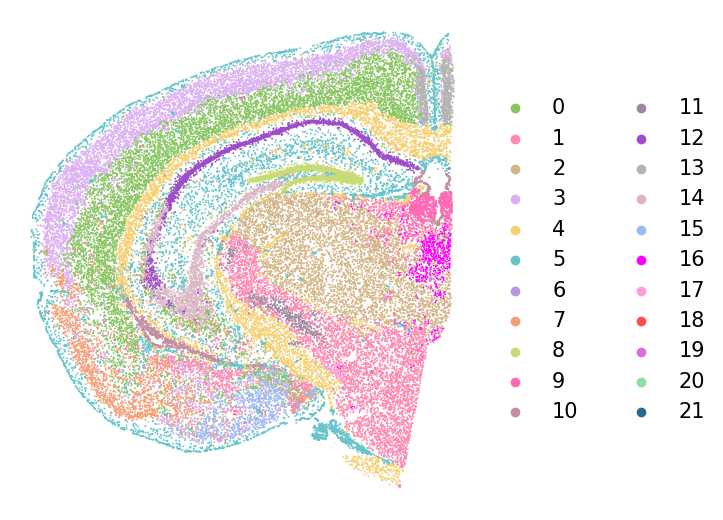

In [12]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (6,6.5)
plt.rcParams['font.size'] = 15
latent_cluster_colors = create_new_color_dict(adata=Pre_train_data,cat_key='SpaLP')
sc.pl.embedding(adata, basis="spatial",s=7,color=['Transfer_label'],colorbar_loc=None,title='',frameon=False,palette=latent_cluster_colors)

### <span style="color:black; font-weight:bold;">Cosine similarity for label transfer</span>

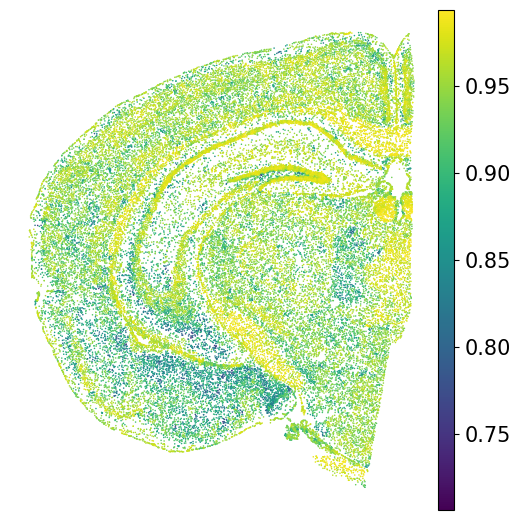

In [13]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (6,6.5)
plt.rcParams['font.size'] = 15
sc.pl.embedding(adata, basis="spatial",s=5, color=['Cosine_confidence'],title='',frameon=False)

## <span style="color:black; font-weight:bold;">Pre-training data and new data Integration embedding</span>

In [93]:
adata.obs['type']='Inference data'
adata_list=[adata,Pre_train_data]
adata_combine = ad.concat(adata_list, join="inner")

In [95]:
sc.pp.neighbors(adata_combine, use_rep='SpaLP')
sc.tl.umap(adata_combine)

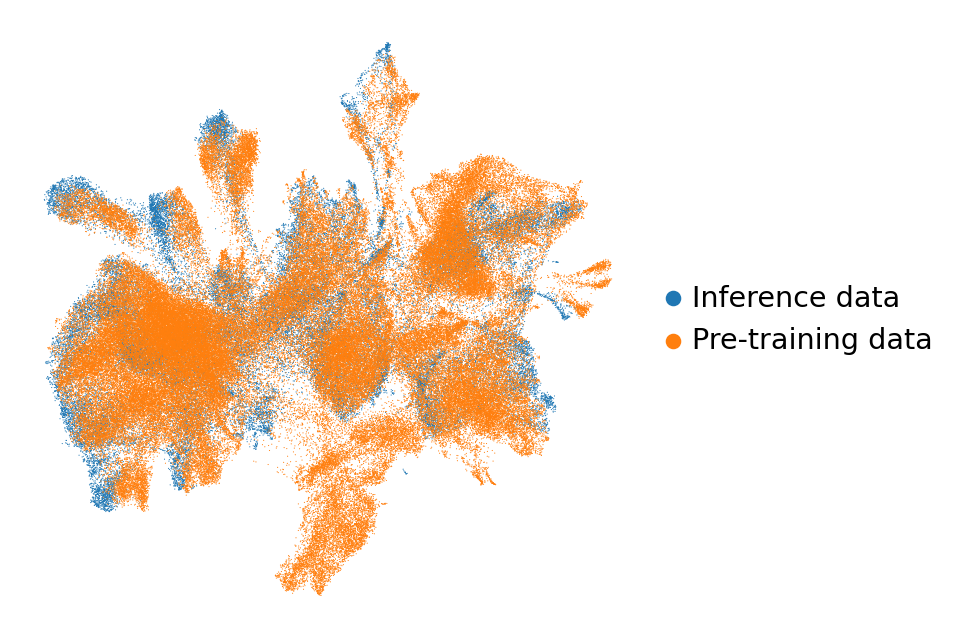

In [99]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.size'] = 15
sc.pl.umap(adata=adata_combine,color='type',title='',size=1,colorbar_loc=None,frameon=False,save='C57BL6J-2.041umap.png')

## <span style="color:black; font-weight:bold;">Sereo-seq</span>

In [192]:
adata=sc.read_h5ad('/home/dbj/SpaLP/generalization/C03937C4.adjusted.h5ad')
Pre_train_data=sc.read_h5ad('/home/dbj/SpaLP/generalization/Pre-training.h5ad')

In [193]:
common_genes = adata.var_names.intersection(Pre_train_data.var_names)
adata = adata[:, Pre_train_data.var_names[Pre_train_data.var_names.isin(common_genes)]].copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata)
adata.obsm['feat']=adata.X

In [195]:
graph = prepare_inputs(adata, k=32, device=device)

In [196]:
in_channels = graph.features.shape[1]
model = SpatialAutoencoder(in_channels, out_channels=32).to(device)
model.load_state_dict(torch.load("/home/dbj/SpaLP/generalization/model_final.pth", map_location="cpu"))
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

In [197]:
adata.obsm['SpaLP']=embedding

In [198]:
adata=transfer_labels_by_cosine(pre_adata=Pre_train_data,new_adata=adata,label_key='SpaLP',embedding_key='SpaLP')

In [199]:
adata

AnnData object with n_obs × n_vars = 70035 × 87
    obs: 'dnbCount', 'area', 'id', 'orig.ident', 'x', 'y', 'Transfer_label', 'Cosine_confidence'
    var: 'mean', 'std'
    uns: 'bin_size', 'bin_type', 'key_record', 'merged', 'resolution', 'sn', 'log1p'
    obsm: 'cell_border', 'spatial', 'feat', 'SpaLP'

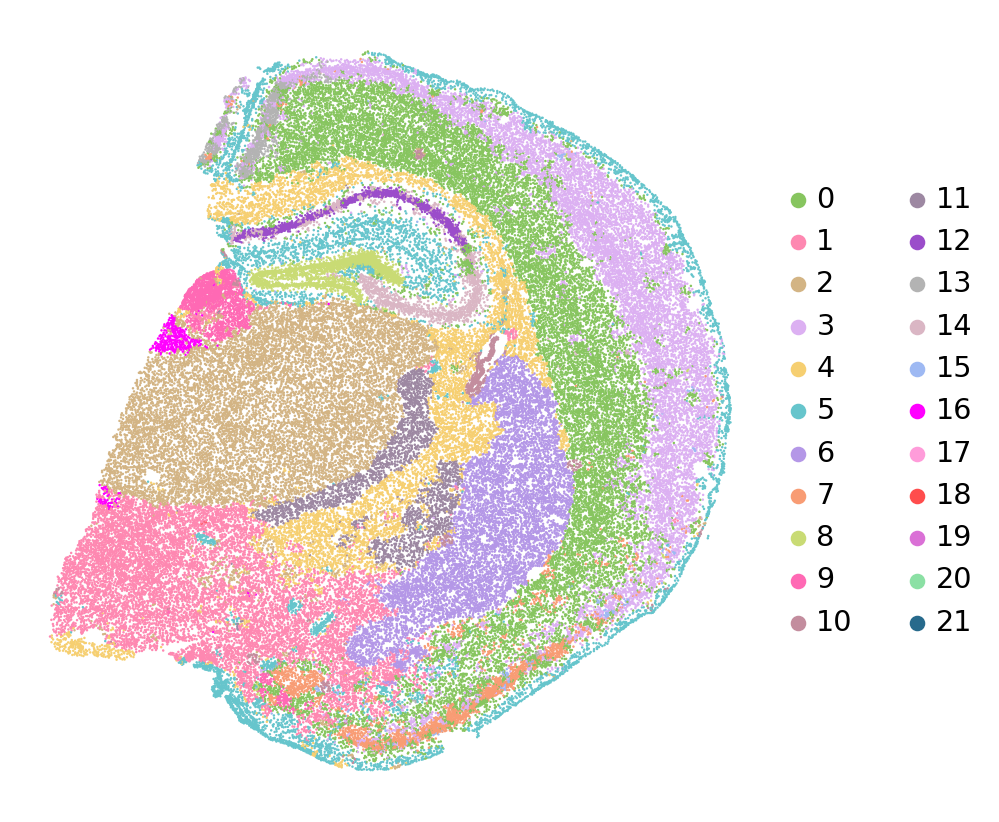

In [202]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (6,6.5)
plt.rcParams['font.size'] = 15
latent_cluster_colors = create_new_color_dict(adata=Pre_train_data,cat_key='SpaLP')
sc.pl.embedding(adata, basis="spatial",s=5,color=['Transfer_label'],colorbar_loc=None,title='',frameon=False,palette=latent_cluster_colors)

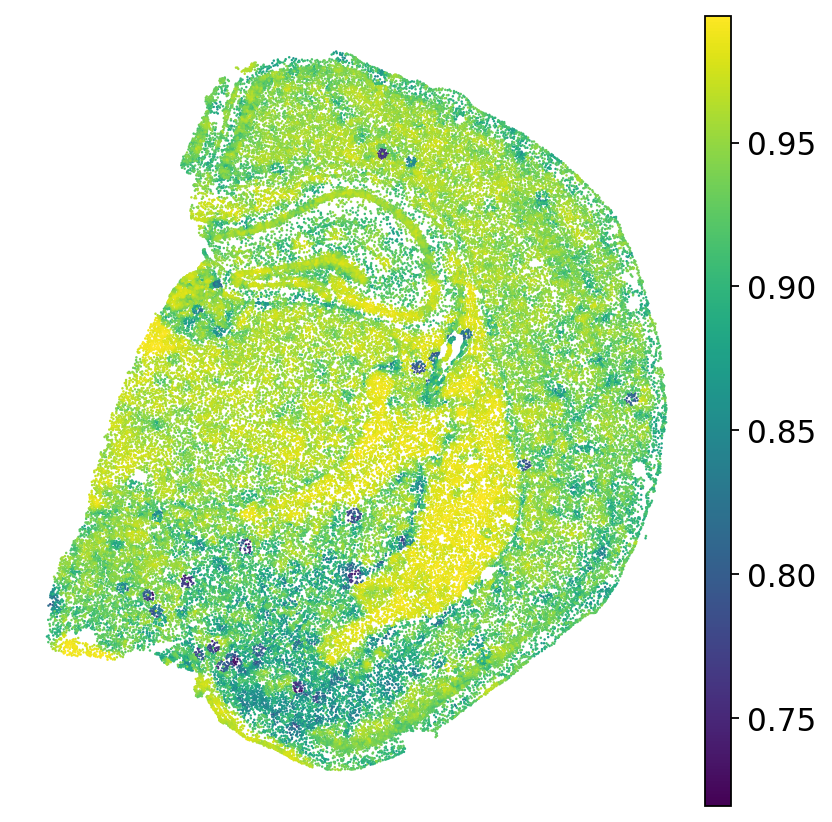

In [201]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (6,6.5)
plt.rcParams['font.size'] = 15
sc.pl.embedding(adata, basis="spatial",s=5, color=['Cosine_confidence'],title='',frameon=False,save='stereoseqcos.png')

In [111]:
adata.obs['type']='Inference data'
adata_list=[adata,Pre_train_data]
adata_combine = ad.concat(adata_list, join="inner")

In [112]:
sc.pp.neighbors(adata_combine, use_rep='SpaLP')
sc.tl.umap(adata_combine)

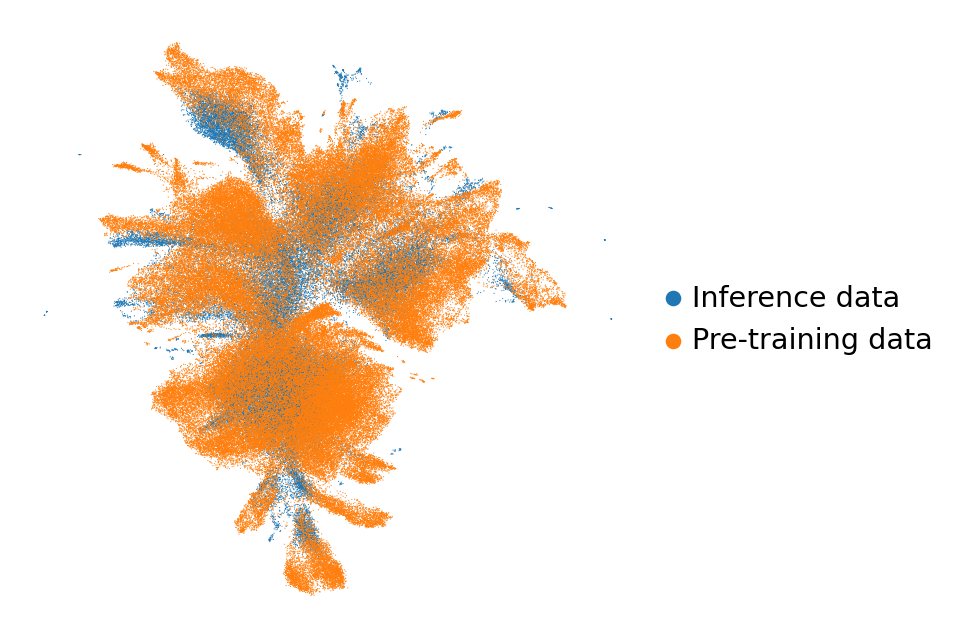

In [120]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.size'] = 15
sc.pl.umap(adata=adata_combine,color='type',title='',size=1,colorbar_loc=None,frameon=False,save='stereoseq.png')